<a href="https://colab.research.google.com/github/kryogenica/Image-compression-using-Matrix-Product-States/blob/master/Image_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matrix Product States to lossly compress images

This notebook is based on the work of the paper titled "[Tensor Networks for Image Compression](http://diposit.ub.edu/dspace/bitstream/2445/96365/1/TFG_Fis_Trujillo_Boque_Alex.pdf)" by Alex Trujillo Boque.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import math
import matplotlib.pyplot as plt

print(tf.__version__)

1.14.0


Images to be used will be from the Fashion-MNIST data set.


In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


## Preprocess the data

The data must be preprocessed before implementing it through the Matrix Product State (MPS) tensor network. If you inspect the first image in the training set (below), its pixel values fall in the range of 0 to 255:

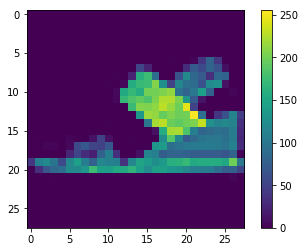

Image 1.


In [3]:
image = train_images[217]
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)
plt.show()
print ('Image 1.')

We scale these values to range from 0 to 1 before trying to compress it through the MPS network. For this, we divide the values by 255.

In [0]:
train_images = train_images / 255.0

test_images = test_images / 255.0

As you can see in the image below its pixel values range from 0 to 1.

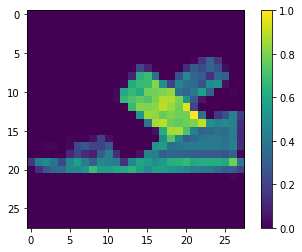

Image 2.


In [5]:
image = train_images[217]
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)
plt.show()
print ('Image 2.')

Before proceeding a small patch of the above image will be extracted. This will be used as a smaller image as to better explain the following content. A requirement to compress an image through the MPS algorithim that we will see ahead is that it should be a square image of sides equal to L.

With ***L*** being a solution to

\begin{equation}
\ n = log_{p} (L^2), \hspace{0.3cm} p=m^2
\end{equation}

under the condition that ***n*** needs to be an integer. The meaning of ***n*** and ***p*** will be explained below.

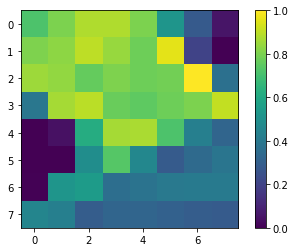

Image 3.


In [6]:
image = train_images[217][11:19,15:23]
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.grid(False)
plt.show()
print ('Image 3.')

In the image above ***L*** clearly equals 4 and ***p*** is equivalent to 2^2.

***p*** is the number of pixels in each square sub-block.

Using the schematic below to label the pixels in the image above and separate it into sub-blocks one sees that ***p*** is 2^2 for this case.  Additionally all pixels have two coordinates assigned to them. This is equivalent to ***n*** in the equation of the text cell above if we where to assign ***L*** and ***p*** the values mentioned in this text cell.


![SubBlockSystem](https://drive.google.com/uc?export=view&id=1JEYmaje0RSEBdKyDnHELD5TU2eYsi0wW)

Image 4.

Using the equation above and with predetermined p value do we calculate the number of croas graining levels in the image.

In [7]:
m = 2
p = m*m
L = image.shape[0]
levels = int(math.log((L*L),p))
print (levels)

3


There is a function within TensorFlow that will allow us to "chop up" the image into sub-blocks and by the same fashion as the schematic above.
The function is ***tf.extract_image_patches***. There is one problem with using it, our "image" is a rank 2 tensor (numpy.ndarray) and this function takes in rank 4 tensors.


So we must convert the image into a rank 4 tensor.



In [8]:
sess = tf.Session()
with sess.as_default():
  tensor = tf.constant(image)
  t = tf.expand_dims(tensor, 0)
  del tensor
  tensor = tf.expand_dims(t, -1)
  del t
  chopped_image = tf.extract_image_patches(images=tensor, ksizes=[1, 2, 2, 1], strides=[1, 2, 2, 1], rates=[1, 1, 1, 1], padding='VALID').eval()
  del tensor
#The reasons that the function takes a 4 rank tensor are:  
#First dimension is the reference to the image itself (this function can take batches of images).
#The second and third dimension is the location of each pixel.
#The fourth dimension is the value of each pixel. In our case its just a grey scale value.

W0713 22:01:50.193909 140033944496000 deprecation.py:506] From <ipython-input-8-bc1f32ce8bb7>:8: calling extract_image_patches (from tensorflow.python.ops.array_ops) with ksizes is deprecated and will be removed in a future version.
Instructions for updating:
ksizes is deprecated, use sizes instead


In [9]:
print (chopped_image)
print (chopped_image.shape)

[[[[0.72156863 0.80392157 0.80784314 0.83137255]
   [0.88235294 0.88235294 0.90196078 0.84705882]
   [0.80392157 0.52156863 0.78039216 0.96078431]
   [0.28235294 0.05490196 0.2        0.        ]]

  [[0.85490196 0.83921569 0.39607843 0.86666667]
   [0.76470588 0.80784314 0.89803922 0.77254902]
   [0.78039216 0.78823529 0.75294118 0.78039216]
   [1.         0.36862745 0.80392157 0.90980392]]

  [[0.         0.04313725 0.         0.        ]
   [0.61960784 0.86666667 0.49019608 0.7372549 ]
   [0.8745098  0.72156863 0.4627451  0.28627451]
   [0.43137255 0.3254902  0.34509804 0.38823529]]

  [[0.00392157 0.52156863 0.45490196 0.43137255]
   [0.54901961 0.36078431 0.29411765 0.3254902 ]
   [0.38039216 0.40392157 0.3254902  0.30980392]
   [0.41176471 0.41176471 0.29411765 0.28627451]]]]
(1, 4, 4, 4)


There is a benifit of using the tensorflow funtion above and it is that our pixels have been given orderly organization. We can explot this further on.

Next lets use our latest result to create a vector to use under a outter product to generate the density matrix of this image.

In [10]:
A = np.reshape(np.squeeze(chopped_image),L*L)
B = np.reshape(A,[1,4,4,4])
print (B)

[[[[0.72156863 0.80392157 0.80784314 0.83137255]
   [0.88235294 0.88235294 0.90196078 0.84705882]
   [0.80392157 0.52156863 0.78039216 0.96078431]
   [0.28235294 0.05490196 0.2        0.        ]]

  [[0.85490196 0.83921569 0.39607843 0.86666667]
   [0.76470588 0.80784314 0.89803922 0.77254902]
   [0.78039216 0.78823529 0.75294118 0.78039216]
   [1.         0.36862745 0.80392157 0.90980392]]

  [[0.         0.04313725 0.         0.        ]
   [0.61960784 0.86666667 0.49019608 0.7372549 ]
   [0.8745098  0.72156863 0.4627451  0.28627451]
   [0.43137255 0.3254902  0.34509804 0.38823529]]

  [[0.00392157 0.52156863 0.45490196 0.43137255]
   [0.54901961 0.36078431 0.29411765 0.3254902 ]
   [0.38039216 0.40392157 0.3254902  0.30980392]
   [0.41176471 0.41176471 0.29411765 0.28627451]]]]


     Density matrix of image


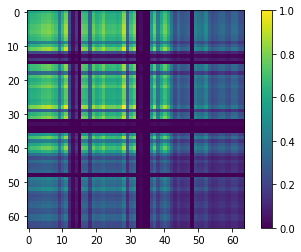

Image 5.


In [11]:
C_vectorized = np.reshape(np.squeeze(chopped_image),L*L)
density_matrix = np.outer(C_vectorized,C_vectorized)
print ('     Density matrix of image')
plt.figure()
plt.imshow(density_matrix)
plt.colorbar()
plt.grid(False)
plt.show()
print ('Image 5.')

In order to continue it is vital to have the ability to assign to each pixel (when spread out as a vector) its coresponding coordinates based, yet again, to the schematic above.

In [0]:
organization = np.ndarray(shape=((L*L),levels))
z = 0
for k in range(0,L*L):
  organization[k,0] = z
  z += 1
  if z==p:
    z = 0

location = organization[:,0].copy()

for k in range(1,levels):
  u = 0
  u_counter = 0
  z = 0
  z_counter = 0
  y = 0
  level_counter = int(math.pow(m,k-1))
  level_above = int(math.pow(m,k))
  l_c = 0
  for i in location:
    organization[y,k] = z
    y += 1
    if i==(p-1):
      l_c += 1
      if l_c==level_counter:
        z += 1
        l_c = 0
        z_counter += 1
        if z_counter==level_above/k:
          z_counter = 0
          z =  u*m
          u_counter += 1
          if u_counter==int(L/math.pow(m,levels-1)):
            u += 1
            z = u*m
            u_counter = 0
            if u==m:
              u=0
              z=0

The way in which the vectorized form of the image has been organized is as follows.
The baseline coordinate here is level 0 where we scan from 0 to ***p***. We move from one sub-block level 0 to another sub-block level 0 strating from the top left corner of the image and move to the right until the last sub-block level 0 in the first sub-block level 0 row is reached. Then we start again from the sub-block level 0 below the first one we started out with and yet again move to the right until the very end of its row. We continue with this methodology until the whole image has been covered. 

In [13]:
print (organization[:14,:])

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [0. 0. 1.]
 [1. 0. 1.]
 [2. 0. 1.]
 [3. 0. 1.]
 [0. 1. 1.]
 [1. 1. 1.]]


The next step is to create a density matrix of the image. A first stride to achieve this is to assign to each pixel in the orginal image a corresponding value for each one of its coarse graining levels. 

In [14]:
Coarse0 = np.reshape(organization[:,0],[1,64])
Coarse1 = np.reshape(organization[:,1],[1,64])
Coarse2 = np.reshape(organization[:,2],[1,64])
levelValues = np.hstack((Coarse0,Coarse1,Coarse2))
levelValues_vectorized = np.reshape(levelValues,(64,3),order='F')

imaged_vectorized = np.reshape(chopped_image,[1,64])
imageWithLevels = np.hstack((imaged_vectorized,Coarse0,Coarse1,Coarse2))
imageWithLevels_vectorized = np.reshape(imageWithLevels,(64,4),order='F')

print (imageWithLevels_vectorized[:14,:])

[[0.72156863 0.         0.         0.        ]
 [0.80392157 1.         0.         0.        ]
 [0.80784314 2.         0.         0.        ]
 [0.83137255 3.         0.         0.        ]
 [0.88235294 0.         1.         0.        ]
 [0.88235294 1.         1.         0.        ]
 [0.90196078 2.         1.         0.        ]
 [0.84705882 3.         1.         0.        ]
 [0.80392157 0.         0.         1.        ]
 [0.52156863 1.         0.         1.        ]
 [0.78039216 2.         0.         1.        ]
 [0.96078431 3.         0.         1.        ]
 [0.28235294 0.         1.         1.        ]
 [0.05490196 1.         1.         1.        ]]


Now we can construct the density matrix. We create a structure that contains diferent layers, of which the first layer is the outter product of the image portraied in Image 5. (Array: "densityMatrix" ).
The remainding layers are the kets and bras of each pixel stack on top of each other. This makes layers 1 to ***n*** the kets values and from layer ***n***+1 to 2***n***  the bra values.

In [15]:
print (levelValues_vectorized.shape)

(64, 3)


Below bra and kets are adjoined to each outter product pixel value.

In [175]:
d = levelValues_vectorized.shape[0]
levels = levelValues_vectorized.shape[1]
densityMatrix = np.zeros([d,d,((2*levels)+1)])
ii=0
jj=0
for i in levelValues_vectorized:
  for j in levelValues_vectorized:
    kk=0
    ket_bra = np.hstack(((imaged_vectorized[0,ii]*imaged_vectorized[0,jj]),i,j))
    densityMatrix[ii,jj,:] = ket_bra
    jj += 1
  jj=0
  ii += 1

print ("These are the two first ([0,0] & [0,1]) outter product values with their respectives bra and ket vectors stacked to them.\n")
print (densityMatrix[0,0:2,:])

These are the two first ([0,0] & [0,1]) outter product values with their respectives bra and ket vectors stacked to them.

[[0.52066128 0.         0.         0.         0.         0.
  0.        ]
 [0.58008458 0.         0.         0.         1.         0.
  0.        ]]


Create own method to do partial traces using the above structure.
Every pixel now has 2**n** + 1 dimensions.

First create the indicies to locate sub matrices within the density matrix

In [0]:
#print (density_matrix.shape)
#print (templateArray.shape)
from itertools import combinations, product

m=1

def Trace_sub_index(p, m): 
    return list(product(list(range(p)), repeat=m))



# Get all permutations of [0, 1, 2, 3] in r-lenght tupel 
sub_index = Trace_sub_index(p,(levels-m))
index = Trace_sub_index(p, m)

Lets print the locating indices

In [180]:
print ("index: to locate sub matrices")
for i in list(index): 
  print (np.asanyarray(i))
  
print ("")

print ("sub_index: these are the term to be summed within the sub matrix")
for i in list(sub_index): 
  print (np.asanyarray(i))

index: to locate sub matrices
[0]
[1]
[2]
[3]

sub_index: these are the term to be summed within the sub matrix
[0 0]
[0 1]
[0 2]
[0 3]
[1 0]
[1 1]
[1 2]
[1 3]
[2 0]
[2 1]
[2 2]
[2 3]
[3 0]
[3 1]
[3 2]
[3 3]


**Partial trace script**

In [0]:
partial_trace = np.empty([len(index),len(index)]) #create an empty matrix for the partial trace of the density matrix
ii = 0
jj = 0 #these will be used to navigate through the empty trace to populate it
sum = 0
for i in index:
  for j in index:
    for z in sub_index:
      # i,j,z are use to re-create the ket bra stack
      val = np.asanyarray(i+z+j+z)
      
      #locate a the matching bra ket vector in our density matrix 
      locate = str(np.where((densityMatrix[:,:,1:] == val).all(axis=2)))
      string = [int(s) for s in locate.split() if s.isdigit()]
      #Removing unnessary characters from returned value of the above function
      locate = locate.replace("array", "")
      locate = locate.replace("[", "")
      locate = locate.replace("]", "")
      locate = locate.replace("(", "")
      locate = locate.replace(")", "")
      locate = locate.replace(",", "")
      locate = np.asanyarray(list(map(int, locate.split())))
      
      #sum up the terms within the sub matrix
      sum = sum + densityMatrix[locate[0],locate[1],0]
    
    partial_trace[ii,jj] = sum
    sum = 0
    jj += 1
  jj = 0
  ii += 1

In [187]:
print ('Partial trace:')
print (partial_trace)

Partial trace:
[[6.90031526 5.94414456 5.74491349 6.26094579]
 [5.94414456 5.92845829 5.27803153 5.77613226]
 [5.74491349 5.27803153 5.35112649 5.64632065]
 [6.26094579 5.77613226 5.64632065 6.36267589]]


In [188]:
from numpy import linalg as LA
w, v = LA.eig(partial_trace)
print('Eigenvalues of partial trace:')
print (w)

print ('')
print ('Eigenvectors of partial trace:')
print (v)

Eigenvalues of partial trace:
[23.51091411  0.45113099  0.3932915   0.18723933]

Eigenvectors of partial trace:
[[ 5.29569729e-01  6.47777853e-01  5.45681421e-01  4.65997938e-02]
 [ 4.87847212e-01 -7.59526867e-01  4.29831220e-01 -1.92134892e-02]
 [ 4.68493397e-01  5.91825761e-02 -4.60741488e-01 -7.51484292e-01]
 [ 5.11932551e-01 -4.63193702e-04 -5.52443833e-01  6.57822666e-01]]
